## Import Library

In [2]:
# Import Dependencies
import pandas as pd
import numpy as np
from sklearn import tree
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_selector , make_column_transformer
from apyori import apriori
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import random
from sklearn.preprocessing import MinMaxScaler
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.optimizers import Adam
import scipy
from sklearn import metrics
import seaborn
%matplotlib inline

## Thydroid Dataset

Data Preparation

In [21]:
#Chuẩn hóa các giá trị sang dạng int 
thyroid_df = pd.read_csv('thyroidDF.csv')
thyroid_df['TBG'].fillna(0,inplace=True)
thyroid_df['referral_source'].unique()
rs_encoder = { 'other' : 0, 'SVI' : 1, 'SVHC' : 2, 'STMW' : 3, 'SVHD' : 4, 'WEST' : 5}
thyroid_df['referral_source'] = thyroid_df['referral_source'].map(rs_encoder)
thyroid_df['referral_source']

0       0
1       0
2       0
3       0
4       0
       ..
9167    1
9168    1
9169    1
9170    0
9171    0
Name: referral_source, Length: 9172, dtype: int64

In [22]:
#Chuẩn hóa các giá trị sang dạng int 
data = thyroid_df.select_dtypes(include='object')
data['sex'] = data['sex'].map({'F' : 0, 'M' : 1})
cols = data.loc[:, ~data.columns.isin(['sex','target','referral_source'])] 
for c in cols:
    data[c] = data[c].map({'f' : 0, 't' : 1})
data['age'] = thyroid_df['age']
data['TT4'] = thyroid_df['TT4']
data['T4U'] = thyroid_df['T4U'] 
data['FTI'] = thyroid_df['FTI']
data['TBG'] = thyroid_df['TBG'] 
data

,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_meds,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,query_hyperthyroid,...,TT4_measured,T4U_measured,FTI_measured,TBG_measured,target,age,TT4,T4U,FTI,TBG
0,0.0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,-,29,NaN,NaN,NaN,0.0
1,0.0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,-,29,128.0,NaN,NaN,0.0
2,0.0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,-,41,NaN,NaN,NaN,11.0
3,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,-,36,NaN,NaN,NaN,26.0
4,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,S,32,NaN,NaN,NaN,36.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9167,1.0,0,0,0,0,0,0,0,0,1,...,1,1,1,0,-,56,64.0,0.83,77.0,0.0
9168,1.0,0,0,0,0,0,0,0,0,0,...,1,1,1,0,-,22,91.0,0.92,99.0,0.0
9169,1.0,0,0,0,0,0,0,0,0,0,...,1,1,1,0,I,69,113.0,1.27,89.0,0.0
9170,0.0,0,0,0,0,0,0,0,0,0,...,1,1,1,0,-,47,75.0,0.85,88.0,0.0


In [23]:
#Sử dụng Mean imputation để giảm bớt giá trị bị thiếu
data['sex'].fillna(data['sex'].median(), inplace=True)
data['TT4'].fillna(data['TT4'].median(), inplace=True)
data['T4U'].fillna(data['T4U'].median(), inplace=True)
data['FTI'].fillna(data['FTI'].median(), inplace=True)
data

,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_meds,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,query_hyperthyroid,...,TT4_measured,T4U_measured,FTI_measured,TBG_measured,target,age,TT4,T4U,FTI,TBG
0,0.0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,-,29,104.0,0.96,109.0,0.0
1,0.0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,-,29,128.0,0.96,109.0,0.0
2,0.0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,-,41,104.0,0.96,109.0,11.0
3,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,-,36,104.0,0.96,109.0,26.0
4,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,S,32,104.0,0.96,109.0,36.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9167,1.0,0,0,0,0,0,0,0,0,1,...,1,1,1,0,-,56,64.0,0.83,77.0,0.0
9168,1.0,0,0,0,0,0,0,0,0,0,...,1,1,1,0,-,22,91.0,0.92,99.0,0.0
9169,1.0,0,0,0,0,0,0,0,0,0,...,1,1,1,0,I,69,113.0,1.27,89.0,0.0
9170,0.0,0,0,0,0,0,0,0,0,0,...,1,1,1,0,-,47,75.0,0.85,88.0,0.0


### Classification using Random Forest

In [24]:
thyroid_df_copy = data.copy()

neg = np.delete(thyroid_df_copy['target'].unique(), np.where(np.isin(thyroid_df_copy['target'].unique(), '-')))
thyroid_df_copy['target'] = thyroid_df_copy['target'].replace('-', '0')
for t in neg:
    thyroid_df_copy['target'] = thyroid_df_copy['target'].replace(t, '1')

thyroid_df_copy['target'] = thyroid_df_copy['target'].astype(int)
thyroid_df_copy['target'].unique()

array([0, 1])

In [25]:

y_thyroid = thyroid_df_copy['target']
X_thyroid = thyroid_df_copy.drop('target',axis=1)
X_thyroid_train, X_thyroid_test, y_thyroid_train, y_thyroid_test = train_test_split(X_thyroid, y_thyroid, test_size=0.2)

In [26]:
# Khởi tạo mô hình Random Forest tìm số cây quyết định
n_estimators_range = range(100, 500, 10)
acc_score = []
num_tree = []
for n in n_estimators_range:
    mod_check = RandomForestClassifier(n_estimators = n, max_depth=20, criterion= 'entropy')
    mod_check = mod_check.fit(X_thyroid_train,y_thyroid_train)
    pred = mod_check.predict(X_thyroid_test)
    acc_score.append(accuracy_score(y_thyroid_test, pred))
    num_tree.append(n)

In [27]:
best_acc_vt = acc_score.index(max(acc_score))
print(n_estimators_range[best_acc_vt])

130


In [28]:
#xây dựng model
mod = RandomForestClassifier(n_estimators = n_estimators_range[best_acc_vt], max_depth=20, criterion= 'entropy')
mod = mod.fit(X_thyroid_train,y_thyroid_train)
pred = mod.predict(X_thyroid_test)
accuracy_score(y_thyroid_test, pred)

0.8713896457765667

In [29]:
from sklearn.metrics import classification_report
report = classification_report(y_thyroid_test, pred, output_dict=True)
pd.DataFrame(report).transpose()

,precision,recall,f1-score,support
0,0.873467,0.971285,0.919782,1393.00000
1,0.860140,0.556561,0.675824,442.00000
accuracy,0.871390,0.871390,0.871390,0.87139
macro avg,0.866803,0.763923,0.797803,1835.00000
weighted avg,0.870257,0.871390,0.861020,1835.00000


<Axes: >

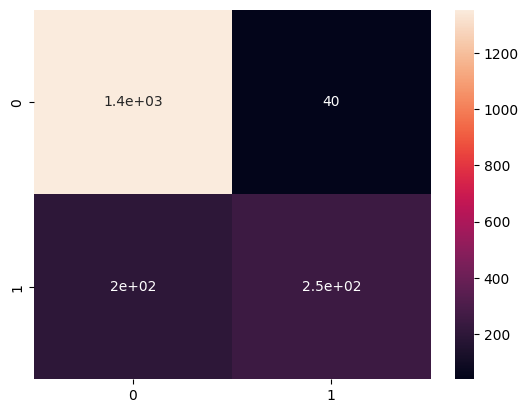

In [30]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
# Tính toán confusion matrix từ y_thyroid_test và pred
cm = confusion_matrix(y_thyroid_test, pred)

# Vẽ confusion matrix dưới dạng biểu đồ
sns.heatmap(cm, annot=True)

### Association Rules using Apriori

In [31]:
#Lấy danh sách những người không bệnh
thyroid_pos = thyroid_df[thyroid_df['target'] != '-' ]
thyroid_neg = thyroid_df[thyroid_df['target'] == '-' ]

In [32]:
#Tạo itemset cho các thuộc tính - Tập dương tính
pos_records = []
for i in range(0, thyroid_pos.shape[0]):
    temp = []
    for j in range(0, thyroid_pos.shape[1]):
        if thyroid_pos.iat[i,j] == 't':
            temp.append(thyroid_pos.columns[j])
        if j==1:
            if thyroid_pos.iat[i,j] == 'M':
                temp.append('Male')
            if thyroid_pos.iat[i,j] == 'F':
                temp.append('Female')
    if len(temp) != 0 :
        pos_records.append(temp)

In [33]:
#Tạo itemset cho các thuộc tính - Tập âm tính
neg_records = []
for i in range(0, thyroid_neg.shape[0]):
    temp = []
    for j in range(0, thyroid_neg.shape[1]):
        if thyroid_neg.iat[i,j] == 't':
            temp.append(thyroid_neg.columns[j])
        if j==1:
            if thyroid_neg.iat[i,j] == 'M':
                temp.append('Male')
            if thyroid_neg.iat[i,j] == 'F':
                temp.append('Female')
    if len(temp) != 0 :
        neg_records.append(temp)

In [34]:
pos_records

[['Female', 'TBG_measured'],
 ['Female',
  'on_thyroxine',
  'sick',
  'TSH_measured',
  'TT4_measured',
  'T4U_measured',
  'FTI_measured'],
 ['Female',
  'TSH_measured',
  'T3_measured',
  'TT4_measured',
  'T4U_measured',
  'FTI_measured'],
 ['Male',
  'TSH_measured',
  'T3_measured',
  'TT4_measured',
  'T4U_measured',
  'FTI_measured'],
 ['Female',
  'on_thyroxine',
  'TSH_measured',
  'TT4_measured',
  'T4U_measured',
  'FTI_measured'],
 ['Female',
  'on_thyroxine',
  'query_hypothyroid',
  'TSH_measured',
  'T3_measured',
  'TT4_measured',
  'T4U_measured',
  'FTI_measured'],
 ['Female',
  'on_thyroxine',
  'TSH_measured',
  'T3_measured',
  'TT4_measured',
  'T4U_measured',
  'FTI_measured'],
 ['Female', 'TSH_measured', 'TT4_measured', 'T4U_measured', 'FTI_measured'],
 ['Female',
  'on_thyroxine',
  'I131_treatment',
  'TSH_measured',
  'T3_measured',
  'TT4_measured',
  'T4U_measured',
  'FTI_measured'],
 ['Male',
  'sick',
  'TSH_measured',
  'T3_measured',
  'TT4_measured',


In [35]:
neg_records

[['Female', 'query_hypothyroid', 'TSH_measured'],
 ['Female', 'TSH_measured', 'T3_measured', 'TT4_measured'],
 ['Female', 'query_hyperthyroid', 'TBG_measured'],
 ['Female', 'TBG_measured'],
 ['Female', 'TBG_measured'],
 ['Female', 'TBG_measured'],
 ['Female', 'TSH_measured', 'T3_measured', 'TT4_measured'],
 ['Female', 'TSH_measured', 'T3_measured', 'TT4_measured'],
 ['Female', 'TSH_measured', 'T3_measured', 'TT4_measured'],
 ['Female', 'TSH_measured', 'T3_measured', 'TT4_measured'],
 ['Female', 'TSH_measured', 'T3_measured', 'TT4_measured'],
 ['Male', 'on_thyroxine', 'TSH_measured'],
 ['Female', 'TSH_measured', 'T3_measured', 'TT4_measured'],
 ['Female', 'tumor', 'T3_measured'],
 ['Male', 'TSH_measured'],
 ['Female', 'TSH_measured', 'T3_measured', 'TT4_measured'],
 ['Male', 'T3_measured', 'TT4_measured'],
 ['Female',
  'query_hypothyroid',
  'query_hyperthyroid',
  'TSH_measured',
  'T3_measured',
  'TT4_measured',
  'T4U_measured',
  'FTI_measured'],
 ['Female',
  'query_on_thyroxine'

In [36]:
#Thiết lập thuật toán apriori
pos_association_rules = apriori(pos_records, min_support=20/len(thyroid_pos), min_confidence=0.4, min_lift=2, min_length=2)
neg_association_rules = apriori(neg_records, min_support=20/len(thyroid_neg), min_confidence=0.4, min_lift=2, min_length=2)
#min_support : chọn item với giá trị support lớn hơn hoặc bằng giá trị này
#min_confidence : lọc các luật khai phát sao cho độ confidence lớn hơn hoặc bằng giá trị này
#min_lift : giá trị lift nhỏ nhất của các luật 
#min_length : số lượng item nhỏ nhất trong itemset của luật
pos_association_results = list(pos_association_rules)
neg_association_results = list(neg_association_rules)

In [37]:
print("Pos : " + str(len(pos_association_results)))
print("Neg : " + str(len(neg_association_results)))

Pos : 32
Neg : 16


In [38]:
#In các luật khai phá
pos_association_results_df = pd.DataFrame(columns=['Rule', 'Support', 'Confidence', 'Lift'])
neg_association_results_df = pd.DataFrame(columns=['Rule', 'Support', 'Confidence', 'Lift'])
for item in pos_association_results:
    pair = item[0]
    items = [x for x in pair]
    rule = ''
    for i in range (0, len(items)):
        if i < len(items)-1:
                rule = rule + items[i] + '  +  '
        else:
            rule = rule + items[i]
    support = item[1]
    confidence = item[2][0][2]
    lift = item[2][0][3]
    pos_association_results_df = pos_association_results_df.append({'Rule' : rule, 'Support' : support, 'Confidence' : confidence, 'Lift' : lift}, ignore_index=True)

for item in neg_association_results:
    pair = item[0]
    items = [x for x in pair]
    rule = ''
    for i in range (0, len(items)):
        if i < len(items)-1:
                rule = rule + items[i] + '  +  '
        else:
            rule = rule + items[i]
    support = item[1]
    confidence = item[2][0][2]
    lift = item[2][0][3]
    neg_association_results_df = neg_association_results_df.append({'Rule' : rule, 'Support' : support, 'Confidence' : confidence, 'Lift' : lift}, ignore_index=True)

AttributeError: 'DataFrame' object has no attribute 'append'

In [ ]:
pos_association_results_df.sort_values(by='Confidence', ascending=False)

,Rule,Support,Confidence,Lift
0,psych + Male,0.010829,0.530612,2.250883
5,TT4_measured + psych + Male,0.010829,0.530612,2.266904
2,T3_measured + psych + Male,0.010412,0.510204,2.552083
4,psych + Male + TSH_measured,0.010412,0.510204,2.243590
15,TT4_measured + psych + Male + TSH_measured,0.010412,0.510204,2.251838
12,TT4_measured + T3_measured + psych + Male,0.010412,0.510204,2.557411
11,T3_measured + psych + Male + TSH_measured,0.009996,0.489796,2.475789
24,Male + T3_measured + psych + TSH_measure...,0.009996,0.489796,2.481013
1,FTI_measured + psych + Male,0.009579,0.469388,2.126415
14,TT4_measured + T4U_measured + psych + Male,0.009579,0.469388,2.126415


In [ ]:
pos_association_results_df.sort_values(by='Confidence', ascending=False).iloc[0,0]
#https://www.mayoclinic.org/diseases-conditions/hyperthyroidism/expert-answers/thyroid-disease/faq-20058228#:~:text=Yes%2C%20thyroid%20disease%20can%20affect,more%20severe%20the%20mood%20changes.

'psych  +  Male'

In [ ]:
neg_association_results_df.sort_values(by='Confidence', ascending=False)

,Rule,Support,Confidence,Lift
1,FTI_measured + Female + T3_measured + pr...,0.003249,0.846154,2.082627
4,Female + T3_measured + pregnant + TSH_me...,0.003249,0.846154,2.086419
7,FTI_measured + Female + T3_measured + pr...,0.003249,0.846154,2.086419
9,FTI_measured + Female + T3_measured + pr...,0.003249,0.846154,2.086419
12,Female + T3_measured + pregnant + TSH_me...,0.003249,0.846154,2.087179
14,FTI_measured + Female + T3_measured + pr...,0.003249,0.846154,2.087179
0,FTI_measured + Female + T3_measured + pr...,0.003545,0.827586,2.040636
2,FTI_measured + Female + T3_measured + pr...,0.003545,0.827586,2.036927
5,Female + T3_measured + pregnant + TT4_me...,0.003545,0.827586,2.040636
8,FTI_measured + Female + T3_measured + pr...,0.003545,0.827586,2.041379


In [ ]:
neg_association_results_df.sort_values(by='Confidence', ascending=False).iloc[0,0]
#https://www.utentclinic.com/news/why-hypothyroidism-occurs-in-pregnancy#:~:text=Pregnancy%20causes%20significant%20changes%20in,is%20very%20important%20to%20treat.

'FTI_measured  +  Female  +  T3_measured  +  pregnant  +  TSH_measured'

### Housing Dataset

Data Preparation

In [185]:
def print_evaluate(true, predicted, train=True):  
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    if train:
        print("========Training Result=======")
        print('MAE: ', mae)
        print('MSE: ', mse)
        print('RMSE: ', rmse)
        print('R2 Square: ', r2_square)
    elif not train:
        print("=========Testing Result=======")
        print('MAE: ', mae)
        print('MSE: ', mse)
        print('RMSE: ', rmse)
        print('R2 Square: ', r2_square)

#Hàm tính khoảng tin cậy
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    #Tính sai số chuẩn và giá trị trung bình
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

In [186]:
train = pd.read_csv("housing_train.csv")
test = pd.read_csv("housing_test.csv")

In [187]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [188]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [189]:
train.isnull().sum().sort_values(ascending = False)


PoolQC         1453
MiscFeature    1406
Alley          1369
Fence          1179
MasVnrType      872
               ... 
ExterQual         0
Exterior2nd       0
Exterior1st       0
RoofMatl          0
SalePrice         0
Length: 81, dtype: int64

In [190]:
#Xoá cột có nhiều giá trị null
train.drop(['Alley','FireplaceQu','PoolQC','Fence','MiscFeature'],axis=1,inplace=True);
test.drop(['Alley','FireplaceQu','PoolQC','Fence','MiscFeature'],axis=1,inplace=True);
train.loc[:, train.isna().any()]

,LotFrontage,MasVnrType,MasVnrArea,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Electrical,GarageType,GarageYrBlt,GarageFinish,GarageQual,GarageCond
0,65.0,BrkFace,196.0,Gd,TA,No,GLQ,Unf,SBrkr,Attchd,2003.0,RFn,TA,TA
1,80.0,NaN,0.0,Gd,TA,Gd,ALQ,Unf,SBrkr,Attchd,1976.0,RFn,TA,TA
2,68.0,BrkFace,162.0,Gd,TA,Mn,GLQ,Unf,SBrkr,Attchd,2001.0,RFn,TA,TA
3,60.0,NaN,0.0,TA,Gd,No,ALQ,Unf,SBrkr,Detchd,1998.0,Unf,TA,TA
4,84.0,BrkFace,350.0,Gd,TA,Av,GLQ,Unf,SBrkr,Attchd,2000.0,RFn,TA,TA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,62.0,NaN,0.0,Gd,TA,No,Unf,Unf,SBrkr,Attchd,1999.0,RFn,TA,TA
1456,85.0,Stone,119.0,Gd,TA,No,ALQ,Rec,SBrkr,Attchd,1978.0,Unf,TA,TA
1457,66.0,NaN,0.0,TA,Gd,No,GLQ,Unf,SBrkr,Attchd,1941.0,RFn,TA,TA
1458,68.0,NaN,0.0,TA,TA,Mn,GLQ,Rec,FuseA,Attchd,1950.0,Unf,TA,TA


In [191]:
#Xử lí các thuộc tính có giá trị bị thiếu của tập train
missing = train.columns[train.isna().any()].to_list()
for col in missing:
    if(train[col].dtypes =='float64'):
        mini= int(train[col].quantile(0.25))
        maxi= int(train[col].quantile(0.75))
        listind=train[train[col].isnull()].index.tolist()
        for i in listind:
                train.loc[i,col]=random.randint(mini,maxi)
        train[col]=pd.to_numeric(train[col])
   

    elif(train[col].dtypes == 'object'):
        if('True' in str(train[col].str.contains('No').unique().tolist())):
            train[col].fillna('No',inplace=True)
        elif('True' in str(train[col].str.contains('None').unique().tolist())):
            train[col].fillna('None',inplace=True)
        elif('True' in str(train[col].str.contains('Unf').unique().tolist())):
            train[col].fillna('Unf',inplace=True)
        else:
            listind=train[train[col].isnull()].index.tolist()
            unique = train[col].unique().tolist()
            unique=pd.Series(unique).dropna().tolist()
            for i in listind:
                train.loc[i,col]=random.choice(unique)

In [192]:
#Xử lí các thuộc tính có giá trị bị thiếu của tập test
missing = test.columns[test.isna().any()].to_list()
for col in missing:
    if(test[col].dtypes=='float64'):
        mini= int(test[col].quantile(0.25))
        maxi= int(test[col].quantile(0.75))
        listind=test[test[col].isnull()].index.tolist()
        for i in listind:
                test.loc[i,col]=float(random.randint(mini,maxi))
        test[col]=pd.to_numeric(test[col]) 
        
    if(test[col].dtypes=='object'):
        if('True' in str(test[col].str.contains('No').unique().tolist())):
            test[col].fillna('No',inplace=True)
        elif('True' in str(test[col].str.contains('None').unique().tolist())):
            test[col].fillna('None',inplace=True)
        elif('True' in str(test[col].str.contains('Unf').unique().tolist())):
            test[col].fillna('Unf',inplace=True)
        else:
            listind=test[test[col].isnull()].index.tolist()
            unique = test[col].unique().tolist()
            unique=pd.Series(unique).dropna().tolist()
            for i in listind:
                test.loc[i,col]=random.choice(unique)

In [193]:
train_x = train.iloc[:,:-1]
train_y= train.iloc[:,-1]


In [194]:
#Mã hoá dữ liệu sang dạng 0,1 (False, True)
objects = train.columns[train.dtypes == 'object'].to_list()
train_x=pd.get_dummies(train_x,columns=objects)
for i in objects:
    cols = train_x.filter(like=i).columns
    train_x.drop(cols[0],axis=1,inplace=True)
    
objects = test.columns[test.dtypes == 'object'].to_list()
test=pd.get_dummies(test,columns=objects)
for i in objects:
    cols = test.filter(like=i).columns
    test.drop(cols[0],axis=1,inplace=True)

missing = (list(set(train_x.columns) - set(test.columns)))
train_x.drop(columns = missing,axis = 1,inplace=True)
train_x.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,False,False,False,False,True,False,False,False,True,False
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,False,False,False,False,True,False,False,False,True,False
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,False,False,False,False,True,False,False,False,True,False
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,False,False,False,False,True,False,False,False,False,False
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,False,False,False,False,True,False,False,False,True,False


In [195]:
train_x.drop('Id',axis=1,inplace = True)
test.drop('Id',axis=1,inplace = True)

In [196]:
len(train.columns)

76

### Modeling on Linear Regression

In [197]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

lr.fit(train_x, train_y)

LinearRegression()

In [198]:
y_train_pred = lr.predict(train_x)
y_test_pred = lr.predict(test)

print_evaluate(train_y, y_train_pred, train=True)


========Training Result=======
MAE:  15389.649511844287
MSE:  597975402.001379
RMSE:  24453.53557261974
R2 Square:  0.9051854372619246


In [199]:
temp = test.copy()
temp['Price'] = y_test_pred
temp.corr().sort_values(by = 'Price', ascending =False)[['Price']]

,Price
Price,1.000000
OverallQual,0.831847
GrLivArea,0.735657
GarageCars,0.691442
GarageArea,0.674711
...,...
GarageType_Detchd,-0.394807
BsmtQual_TA,-0.481285
KitchenQual_TA,-0.537254
GarageFinish_Unf,-0.545331


In [ ]:
Chất liệu tổng thể và chất lượng hoàn thiện
Diện tích sinh hoạt trên mặt đất (mặt đất) feet vuông
Kích thước garage theo sức chứa ô tô
Kích thước garage theo feet vuông

### Modeling on ANN

+ MinMaxScaler là một phép tỷ lệ dữ liệu được sử dụng trong quá trình tiền xử lý dữ liệu để đưa các giá trị về khoảng cụ thể. Nó thường được sử dụng trong các bước chuẩn hóa dữ liệu để đảm bảo rằng các biến độc lập có cùng tỷ lệ và cùng khoảng giá trị.
+ Kết quả của MinMaxScaler là các giá trị mới nằm trong khoảng [0, 1]. Các giá trị nhỏ nhất trong tập dữ liệu được tỷ lệ thành 0, và giá trị lớn nhất được tỷ lệ thành 1. Các giá trị nằm giữa được tỷ lệ tương ứng trong khoảng [0, 1] dựa trên tỷ lệ tương đối của chúng so với các giá trị tương ứng nhỏ nhất và lớn nhất trong tập dữ liệu.

In [200]:
scaler = MinMaxScaler()

train_x = scaler.fit_transform(train_x)
test = scaler.fit_transform(test)

len(train_x)

1460

Giải thích model
+ Layer Dense có các đặc điểm như sau:
    + units: Số lượng node (neuron) trong layer.
    + activation: Hàm kích hoạt được áp dụng cho output của layer.
    + kernel_initializer: Phương pháp khởi tạo trọng số cho layer.
+ Mô hình được biên dịch bằng cách chỉ định các tham số:
    + optimizer: Thuật toán tối ưu hóa (ở đây sử dụng 'adam').
    + loss: Hàm mất mát được sử dụng trong quá trình huấn luyện mô hình (ở đây sử dụng 'mean_squared_error' cho bài toán hồi quy).
    + metrics: Các chỉ số đánh giá hiệu suất của mô hình (ở đây sử dụng 'mean_squared_error' để đánh giá mất mát).
+ Mô hình được huấn luyện trên dữ liệu train_x và train_y với các tham số:
    + epochs: Số lần duyệt qua toàn bộ tập dữ liệu huấn luyện.
    + batch_size: Kích thước của các batch dữ liệu được sử dụng trong quá trình huấn luyện.

In [201]:
from keras.models import Sequential
from keras.layers import Dense,Dropout
regressor = Sequential()
regressor.add(Dense(units=512,activation='relu',kernel_initializer='uniform'))
regressor.add(Dense(units=256,activation='relu',kernel_initializer='uniform'))
regressor.add(Dense(units=256,activation='relu',kernel_initializer='uniform'))
regressor.add(Dense(units=128,activation='relu',kernel_initializer='uniform'))
regressor.add(Dense(units=1,activation='relu',kernel_initializer='uniform'))
#regressor.compile(optimizer='rmsprop', loss='mean_absolute_error', metrics=['mean_absolute_error'])
#regressor.compile(optimizer='sgd', loss='mean_absolute_percentage_error', metrics=['mean_squared_logarithmic_error'])

regressor.compile(optimizer='adam',loss='mean_squared_error',metrics=['mean_squared_error'])
regressor.fit(train_x,train_y,epochs=100,batch_size=50)


Epoch 1/100
30/30 [==============================] - 0s 2ms/step - loss: 39009820672.0000 - mean_squared_error: 39009820672.0000
Epoch 2/100
30/30 [==============================] - 0s 2ms/step - loss: 34064781312.0000 - mean_squared_error: 34064781312.0000
Epoch 3/100
30/30 [==============================] - 0s 2ms/step - loss: 7978045952.0000 - mean_squared_error: 7978045440.0000
Epoch 4/100
30/30 [==============================] - 0s 3ms/step - loss: 4388180480.0000 - mean_squared_error: 4388180480.0000
Epoch 5/100
30/30 [==============================] - 0s 3ms/step - loss: 3473547008.0000 - mean_squared_error: 3473547008.0000
Epoch 6/100
30/30 [==============================] - 0s 3ms/step - loss: 2909076480.0000 - mean_squared_error: 2909076480.0000
Epoch 7/100
30/30 [==============================] - 0s 3ms/step - loss: 2512612608.0000 - mean_squared_error: 2512612608.0000
Epoch 8/100
30/30 [==============================] - 0s 3ms/step - loss: 2208398080.0000 - mean_squared_err

In [202]:
y_train_pred = regressor.predict(train_x)
y_test_pred = regressor.predict(test)

print_evaluate(train_y, y_train_pred, train=True)


46/46 [==============================] - 0s 960us/step
========Training Result=======
MAE:  13457.155340325342
MSE:  409287518.49384755
RMSE:  20230.855604591903
R2 Square:  0.9351036564877687


In [203]:
temp['Price'] = y_test_pred

temp.corr().sort_values(by = 'Price', ascending =False)[['Price']]